### **Analyzing and Forecasting Traffic Patterns in California District 3 Using Hierarchical Time Series and Deep Learning**

## **Introduction**

Traffic congestion remains a critical challenge in urban mobility, influencing commute times, environmental sustainability, and overall transportation efficiency. This study leverages historical traffic data from **California’s District 3**, obtained from the **Caltrans Performance Measurement System (PeMS)**, to explore traffic trends and develop predictive models that enhance traffic management and forecasting.

## **Objectives**
The primary goal of this analysis is to **build a hierarchical time series model** to forecast traffic patterns and later incorporate **deep learning models** for enhanced predictive performance. This study follows a structured approach:

1. **Exploratory Data Analysis (EDA):**
   - Conduct a thorough statistical and visual analysis of the traffic data.
   - Identify seasonality, trends, and anomalies in the dataset.
   - Evaluate key traffic variables such as **total flow, average speed, and direction of travel**.

2. **Basic Time Series Modeling:**
   - Apply classical **time series models** such as **ARIMA, SARIMA, and Exponential Smoothing** to develop initial forecasting benchmarks.
   - Assess the performance of these models using standard evaluation metrics.

3. **Hierarchical Time Series Modeling:**
   - Construct **hierarchical time series (HTS) models** to analyze traffic patterns at different levels (e.g., station-level, route-level, and district-level).
   - Explore aggregation and disaggregation techniques for improved forecasting accuracy.

4. **Deep Learning Integration:**
   - Incorporate **deep learning-based forecasting models** such as **LSTMs and Transformer-based models** for more complex pattern recognition.
   - Compare model performance against traditional time series approaches.

5. **Incorporation of Electric Vehicle (EV) Charging Data:**
   - Integrate **EV charging station data** to analyze its impact on traffic congestion and patterns.
   - Develop a unified deep learning model that incorporates both **traffic and EV charging data** for holistic forecasting.

## **Data Source**
The traffic data used in this study is sourced from **PeMS (Caltrans Performance Measurement System)** and can be accessed at the following link:
[PeMS District 3 Traffic Data](https://pems.dot.ca.gov/?dnode=Clearinghouse&type=station_hour&district_id=3&submit=Submit)
The dataset contains **hourly traffic measurements** across multiple stations in District 3, capturing critical variables such as **total flow, speed, and observed percentages**.

## **Significance of the Study**
Accurate traffic forecasting is essential for **transportation planning, congestion mitigation, and infrastructure optimization**. By combining traditional time series techniques with **hierarchical modeling and deep learning**, this study aims to provide a **robust predictive framework** for traffic management in District 3 and beyond.

In [217]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [5]:
# Use a raw string (r"") to avoid path issues
folder_path = r"C:\Users\attafuro\Desktop\Traffic Analysis"  
output_file = os.path.join(folder_path, "merged_traffic_data.csv")

# Find all text files
file_paths = glob.glob(os.path.join(folder_path, "*.txt"))

# Open the output file and process each text file one by one
with open(output_file, "w") as output:
    first_file = True  # Track first file to write column headers

    for file in file_paths:
        print(f"Processing: {file}")

        # Read file in chunks to save memory
        for chunk in pd.read_csv(file, delimiter=",", chunksize=10000):  # Adjust delimiter if needed
            chunk.to_csv(output, index=False, header=first_file, mode="a")
            first_file = False  # After first file, don’t write headers again
        
        # Remove the processed file to free up space
        os.remove(file)
        print(f"Deleted: {file}")

print(f" Merge completed! CSV saved as '{output_file}'.")


Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_06.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_06.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_07.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_07.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_08.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_08.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_09.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_09.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_10.txt
Deleted: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_10.txt
Processing: C:\Users\attafuro\Desktop\Traffic Analysis\d03_text_station_hour_2024_11.txt
Deleted: C:\Users\attafuro\Desktop\T

## Data Cleaning

In [24]:
# Load the merged file
df = pd.read_csv("C:/Users/attafuro/Desktop/Traffic Analysis/merged_traffic_data.csv")

# Display basic info
df.head()

06/01/2024 00:00:00  308511  3  50  E  ML  3.134  216  100     39  ...  \
0  06/01/2024 00:00:00  308512  3  50  W  ML  3.995  195    0  598.0  ...   
1  06/01/2024 00:00:00  311831  3   5  S  OR    NaN  108  100   39.0  ...   
2  06/01/2024 00:00:00  311832  3   5  S  FR    NaN  108  100    0.0  ...   
3  06/01/2024 00:00:00  311844  3   5  N  OR    NaN  216  100  107.0  ...   
4  06/01/2024 00:00:00  311847  3   5  N  OR    NaN  324  100  101.0  ...   

   Unnamed: 32  Unnamed: 33  Unnamed: 34  Unnamed: 35  Unnamed: 36  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 37  Unnamed: 38  Unnamed: 39  Unnamed: 40  Unnamed: 41  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN          NaN  

[5 rows x 42 columns]

In [25]:
# Define the correct column names
column_names = [
    "Timestamp", "Station", "District", "Route", "Direction of Travel", "Lane Type",
    "Station Length", "Samples", "% Observed", "Total Flow", "Avg Occupancy", "Avg Speed",
    "Delay (V_t=35)", "Delay (V_t=40)", "Delay (V_t=45)", "Delay (V_t=50)", "Delay (V_t=55)", "Delay (V_t=60)"
]

In [26]:
# Identify extra columns (Lane N data) and rename accordingly
num_extra_cols = len(df.columns) - len(column_names)
for i in range(1, num_extra_cols // 3 + 1):  
    column_names.extend([
        f"Lane {i} Flow", f"Lane {i} Avg Occ", f"Lane {i} Avg Speed"
    ])

# Apply new column names
df.columns = column_names

# Save the cleaned dataset
cleaned_file_path = "C:/Users/attafuro/Desktop/Traffic Analysis/cleaned_traffic_data.csv"
df.to_csv(cleaned_file_path, index=False)

print(f" Column names fixed! Cleaned data saved as '{cleaned_file_path}'.")

 Column names fixed! Cleaned data saved as 'C:/Users/attafuro/Desktop/Traffic Analysis/cleaned_traffic_data.csv'.


In [180]:
df = pd.read_csv(cleaned_file_path)
df.head()

Timestamp  Station  District  Route Direction of Travel  \
0  06/01/2024 00:00:00   308512         3     50                   W   
1  06/01/2024 00:00:00   311831         3      5                   S   
2  06/01/2024 00:00:00   311832         3      5                   S   
3  06/01/2024 00:00:00   311844         3      5                   N   
4  06/01/2024 00:00:00   311847         3      5                   N   

  Lane Type  Station Length  Samples  % Observed  Total Flow  ...  \
0        ML           3.995      195           0       598.0  ...   
1        OR             NaN      108         100        39.0  ...   
2        FR             NaN      108         100         0.0  ...   
3        OR             NaN      216         100       107.0  ...   
4        OR             NaN      324         100       101.0  ...   

   Lane 5 Avg Speed  Lane 6 Flow  Lane 6 Avg Occ  Lane 6 Avg Speed  \
0               NaN          NaN             NaN               NaN   
1               NaN          NaN             NaN               NaN   
2               NaN          NaN             NaN               NaN   
3               NaN          NaN             NaN               NaN   
4               NaN          NaN             NaN               NaN   

   Lane 7 Flow  Lane 7 Avg Occ  Lane 7 Avg Speed  Lane 8 Flow  Lane 8 Avg Occ  \
0          NaN             NaN               NaN          NaN             NaN   
1          NaN             NaN               NaN          NaN             NaN   
2          NaN             NaN               NaN          NaN             NaN   
3          NaN             NaN               NaN          NaN             NaN   
4          NaN             NaN               NaN          NaN             NaN   

   Lane 8 Avg Speed  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 42 columns]

In [181]:
# Convert 'Timestamp' to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%m/%d/%Y %H:%M:%S")

# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [182]:
df.head()

Timestamp  Station  Route Direction of Travel  Total Flow  Avg Speed  \
0 2024-06-01   308512     50                   W       598.0       63.7   
1 2024-06-01   311831      5                   S        39.0        NaN   
2 2024-06-01   311832      5                   S         0.0        NaN   
3 2024-06-01   311844      5                   N       107.0        NaN   
4 2024-06-01   311847      5                   N       101.0        NaN   

   % Observed  Samples Lane Type  
0           0      195        ML  
1         100      108        OR  
2         100      108        FR  
3         100      216        OR  
4         100      324        OR

In [183]:
# Display initial summary
print(" Initial Data Overview:")
print(df.info())  # Check data types

 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495975 entries, 0 to 9495974
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Timestamp            datetime64[ns]
 1   Station              int64         
 2   Route                int64         
 3   Direction of Travel  object        
 4   Total Flow           float64       
 5   Avg Speed            float64       
 6   % Observed           int64         
 7   Samples              int64         
 8   Lane Type            object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 652.0+ MB
None


In [184]:
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values


Missing Values:
 Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              672053
Avg Speed              3603209
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64


In [185]:
# Fill Total Flow missing values with median of same Route & Lane Type
df['Total Flow'] = df.groupby(['Route', 'Lane Type'])['Total Flow'].transform(lambda x: x.fillna(x.median()))

In [186]:
# Set Avg Speed to 0 where Total Flow is 0
df.loc[df['Total Flow'] == 0, 'Avg Speed'] = 0

In [187]:
# Fill remaining missing Avg Speed values with median of similar Route & Lane Type
df['Avg Speed'] = df.groupby(['Route', 'Lane Type'])['Avg Speed'].transform(lambda x: x.fillna(x.median()))

In [188]:
print(" Missing Values After Cleaning:\n", df.isnull().sum())

 Missing Values After Cleaning:
 Timestamp                  0
Station                    0
Route                      0
Direction of Travel        0
Total Flow                 0
Avg Speed              33601
% Observed                 0
Samples                    0
Lane Type                  0
dtype: int64


In [189]:
# Fill any remaining missing values with the global median Avg Speed
df.loc[:, 'Avg Speed'] = df['Avg Speed'].fillna(df['Avg Speed'].median())

In [190]:
# Optimize numeric columns
df['Total Flow'] = df['Total Flow'].astype('int32')
df['Avg Speed'] = df['Avg Speed'].astype('int32')
df['% Observed'] = df['% Observed'].astype('int16')
df['Samples'] = df['Samples'].astype('int16')
df['Station'] = df['Station'].astype('int32')
df['Route'] = df['Route'].astype('int32')

# Convert categorical columns to category type
df['Direction of Travel'] = df['Direction of Travel'].astype('category')
df['Lane Type'] = df['Lane Type'].astype('category')

In [191]:
df.head()

Timestamp  Station  Route Direction of Travel  Total Flow  Avg Speed  \
0 2024-06-01   308512     50                   W         598         63   
1 2024-06-01   311831      5                   S          39          0   
2 2024-06-01   311832      5                   S           0          0   
3 2024-06-01   311844      5                   N         107          0   
4 2024-06-01   311847      5                   N         101          0   

   % Observed  Samples Lane Type  
0           0      195        ML  
1         100      108        OR  
2         100      108        FR  
3         100      216        OR  
4         100      324        OR

In [192]:
# Extract time features from Timestamp
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Day_of_Week'] = df['Timestamp'].dt.weekday  # Monday = 0, Sunday = 6
df['Hour'] = df['Timestamp'].dt.hour  

# Check updated DataFrame
df.head()

Timestamp  Station  Route Direction of Travel  Total Flow  Avg Speed  \
0 2024-06-01   308512     50                   W         598         63   
1 2024-06-01   311831      5                   S          39          0   
2 2024-06-01   311832      5                   S           0          0   
3 2024-06-01   311844      5                   N         107          0   
4 2024-06-01   311847      5                   N         101          0   

   % Observed  Samples Lane Type  Year  Month  Day  Day_of_Week  Hour  
0           0      195        ML  2024      6    1            5     0  
1         100      108        OR  2024      6    1            5     0  
2         100      108        FR  2024      6    1            5     0  
3         100      216        OR  2024      6    1            5     0  
4         100      324        OR  2024      6    1            5     0

## Exploratory Data Analysis

In [163]:
# Summary of numerical columns
df.describe()

Timestamp       Station         Route  \
count                        9495975  9.495975e+06  9.495975e+06   
mean   2024-09-16 09:07:39.713931520  1.539897e+06  6.455738e+01   
min              2024-06-01 00:00:00  3.085110e+05  5.000000e+00   
25%              2024-07-25 00:00:00  3.160010e+05  5.000000e+01   
50%              2024-09-16 16:00:00  3.192950e+05  6.500000e+01   
75%              2024-11-08 19:00:00  3.047122e+06  8.000000e+01   
max              2024-12-31 23:00:00  3.900024e+06  5.050000e+02   
std                              NaN  1.400130e+06  4.185411e+01   

         Total Flow     Avg Speed    % Observed       Samples       Year  \
count  9.495975e+06  9.495975e+06  9.495975e+06  9.495975e+06  9495975.0   
mean   9.643129e+02  3.930087e+01  7.939264e+01  1.877938e+02     2024.0   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00     2024.0   
25%    9.500000e+01  0.000000e+00  9.200000e+01  1.030000e+02     2024.0   
50%    4.210000e+02  6.200000e+01  1.000000e+02  1.200000e+02     2024.0   
75%    1.245000e+03  6.500000e+01  1.000000e+02  2.400000e+02     2024.0   
max    1.150600e+04  9.900000e+01  1.000000e+02  1.128000e+03     2024.0   
std    1.308506e+03  3.134621e+01  3.804620e+01  1.292097e+02        0.0   

              Month           Day   Day_of_Week          Hour  
count  9.495975e+06  9.495975e+06  9.495975e+06  9.495975e+06  
mean   9.017659e+00  1.579375e+01  2.998893e+00  1.150007e+01  
min    6.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  
25%    7.000000e+00  8.000000e+00  1.000000e+00  6.000000e+00  
50%    9.000000e+00  1.600000e+01  3.000000e+00  1.200000e+01  
75%    1.100000e+01  2.300000e+01  5.000000e+00  1.800000e+01  
max    1.200000e+01  3.100000e+01  6.000000e+00  2.300000e+01  
std    1.997460e+00  8.823053e+00  2.011526e+00  6.922230e+00

In [46]:
# Summary of categorical columns
print("\nCategorical Value Counts:")
print(df[['Direction of Travel', 'Lane Type']].value_counts())


Categorical Value Counts:
Direction of Travel  Lane Type
E                    ML           1258187
W                    ML           1222223
S                    ML           1024964
N                    ML            981681
E                    OR            562479
S                    OR            524473
W                    OR            522779
N                    OR            521387
W                    HV            479642
E                    HV            477987
W                    FR            357548
E                    FR            333865
N                    FR            329329
S                    FR            307541
N                    HV            235489
S                    HV            212593
                     FF             51360
E                    FF             41088
N                    FF             35952
W                    FF             15408
Name: count, dtype: int64


In [63]:
# Set Seaborn theme for consistent styling
sns.set_theme(style="whitegrid")

# Define colorblind-friendly palettes
palette_numerical = sns.color_palette("viridis", 4)  # 4 distinct colors for numerical features
palette_categorical = sns.color_palette("Set2", 2)   # 2 distinct colors for categorical features

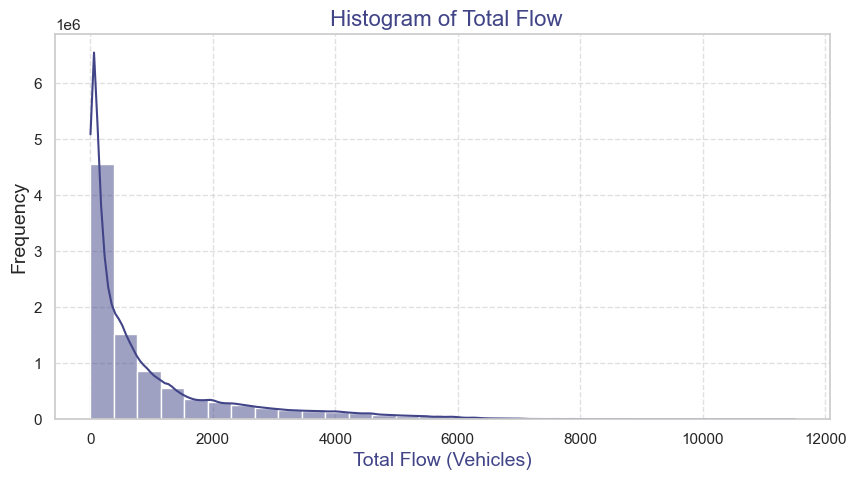

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(df['Total Flow'], bins=30, kde=True, color=palette_numerical[0])
plt.title(" Histogram of Total Flow", fontsize=16, color=palette_numerical[0])
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color=palette_numerical[0])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The distribution of Total Flow (vehicles) is highly right-skewed.
Most traffic observations have a low vehicle count, but there are some high-flow observations.
The long tail suggests there are a few locations or time periods with exceptionally high traffic volumes.
The majority of traffic stations record low traffic volumes.
High-flow locations might represent major highways or peak rush-hour times.

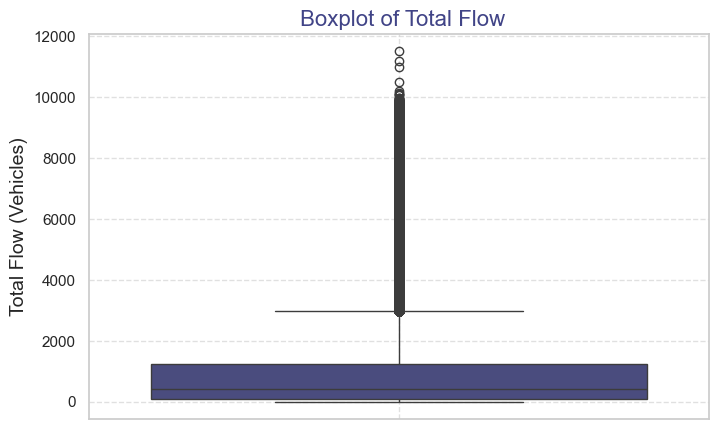

In [65]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Total Flow'], color=palette_numerical[0])
plt.title(" Boxplot of Total Flow", fontsize=16, color=palette_numerical[0])
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
There are many outliers in Total Flow, visible as points above the whiskers.
The median flow is relatively low, with most observations below 2000 vehicles.
Some stations experience very high congestion levels, causing extreme values.
There is high variability in traffic flow across different stations.
The presence of outliers suggests that a few locations experience extremely high congestion.
Further analysis is required to determine whether outliers are anomalies or genuine high-traffic locations.

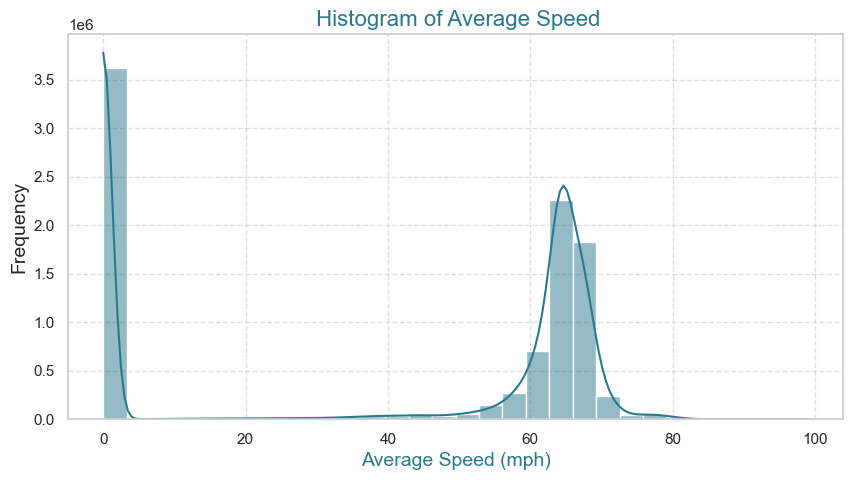

In [68]:
plt.figure(figsize=(10,5))
sns.histplot(df['Avg Speed'], bins=30, kde=True, color=palette_numerical[1])
plt.title(" Histogram of Average Speed", fontsize=16, color=palette_numerical[1])
plt.xlabel("Average Speed (mph)", fontsize=14, color=palette_numerical[1])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Two distinct peaks suggest a bimodal distribution:
One peak at 0-10 mph, possibly representing heavy congestion.
Another peak around 60-70 mph, indicating free-flowing traffic.
The speed data suggests different traffic conditions at different times.
The first peak (near 0 mph) represents locations or times when traffic is heavily congested.
The second peak (65 mph) represents areas with smooth traffic flow.
The mix of slow and fast speeds indicates high variability in traffic conditions.

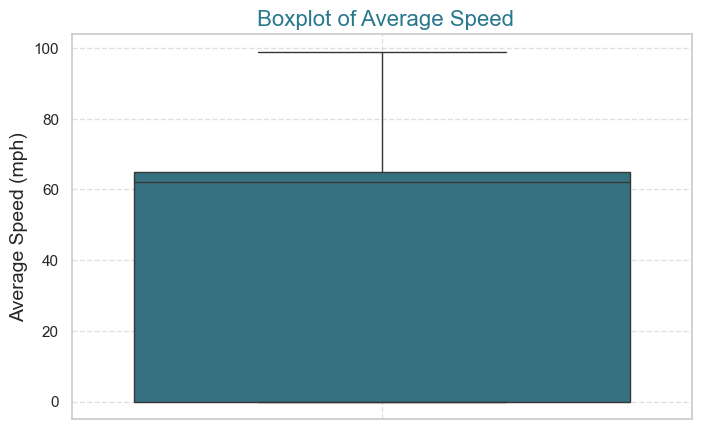

In [69]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Avg Speed'], color=palette_numerical[1])
plt.title(" Boxplot of Average Speed", fontsize=16, color=palette_numerical[1])
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The interquartile range (IQR) is wide, meaning there is significant speed variation across stations.
The whiskers extend to the maximum speed (100 mph), but most observations are below 70 mph.
The lower bound suggests some vehicles are moving extremely slowly or are in congested conditions.
A significant portion of the data represents traffic moving at low speeds.
The large range of speeds suggests multiple traffic scenarios (e.g., urban congestion vs. freeway travel).
Further analysis could focus on identifying patterns in slow-moving vs. fast-moving traffic.

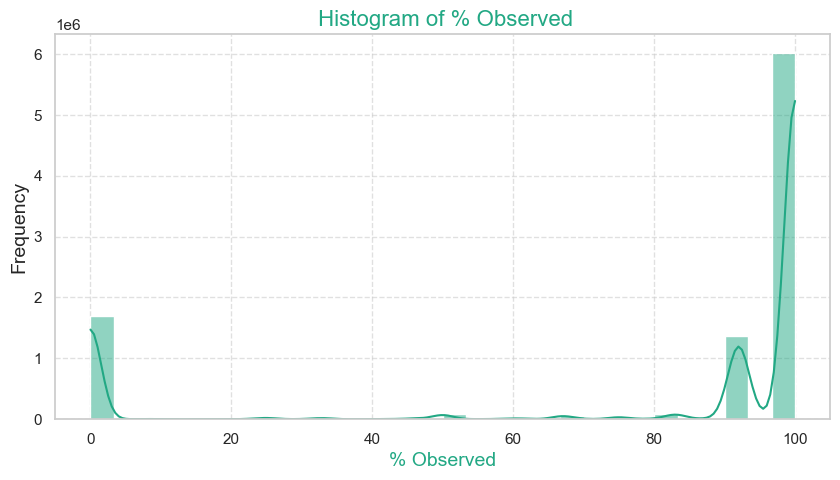

In [70]:
plt.figure(figsize=(10,5))
sns.histplot(df['% Observed'], bins=30, kde=True, color=palette_numerical[2])
plt.title(" Histogram of % Observed", fontsize=16, color=palette_numerical[2])
plt.xlabel("% Observed", fontsize=14, color=palette_numerical[2])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The majority of data points are clustered around 100% or 0%, indicating that:
Some sensors consistently report data fully (100%).
Some sensors are not reporting any data (0%).
This suggests issues related to data collection and sensor coverage.
High % Observed values (near 100%) indicate well-functioning sensors.
Low % Observed values (near 0%) might indicate:
Broken sensors.
Temporary disruptions in data collection.
Unmonitored locations.

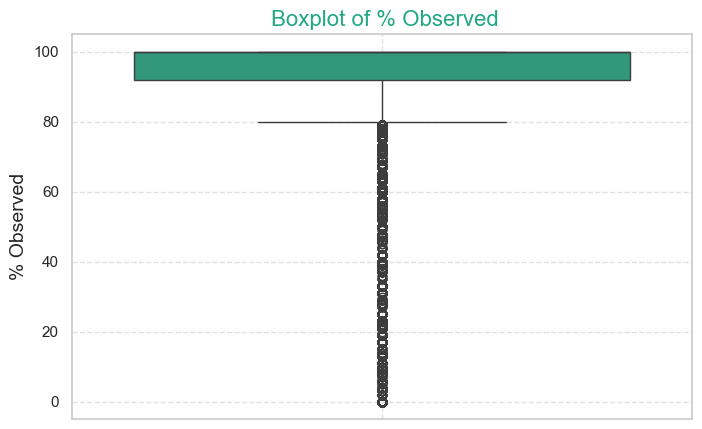

In [71]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['% Observed'], color=palette_numerical[2])
plt.title(" Boxplot of % Observed", fontsize=16, color=palette_numerical[2])
plt.ylabel("% Observed", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
A large number of outliers below 80% suggests significant data loss.
The median is close to 100%, meaning most sensors work well.
The lower whisker extends to 0%, confirming some sensors fail to capture data.

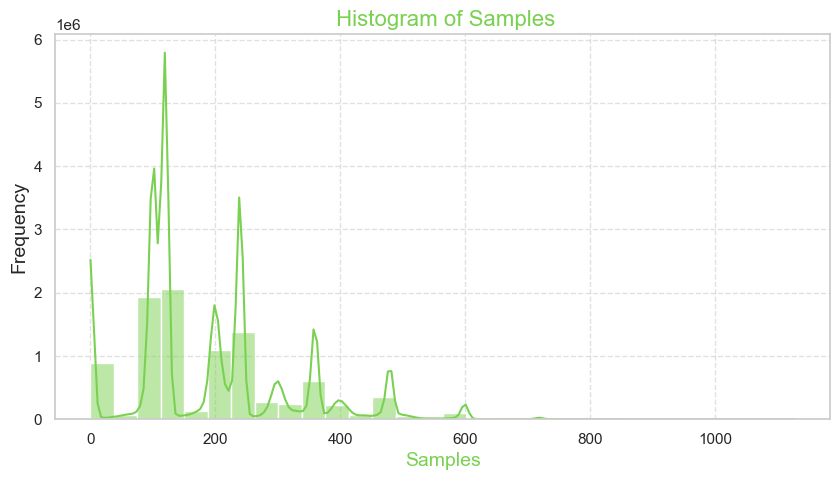

In [122]:
plt.figure(figsize=(10,5))
sns.histplot(df['Samples'], bins=30, kde=True, color=palette_numerical[3])
plt.title(" Histogram of Samples", fontsize=16, color=palette_numerical[3])
plt.xlabel("Samples", fontsize=14, color=palette_numerical[3])
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The distribution of the number of samples collected is multimodal.
Peaks at specific intervals (e.g., 200, 400, 600) suggest standardized data collection rates.
The spikes in frequency suggest traffic sensors operate in predefined sampling intervals.

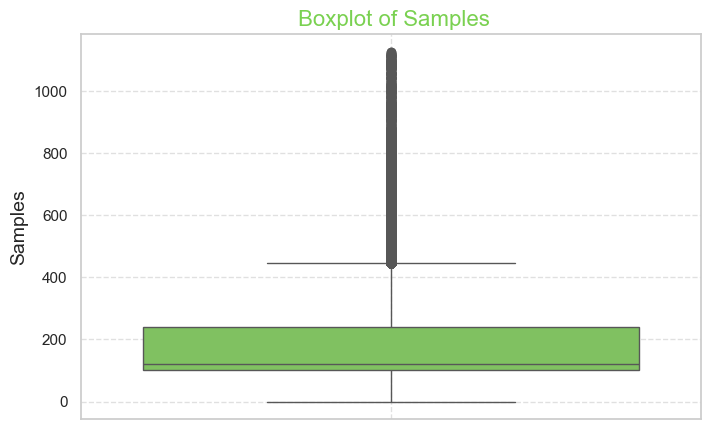

In [73]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['Samples'], color=palette_numerical[3])
plt.title(" Boxplot of Samples", fontsize=16, color=palette_numerical[3])
plt.ylabel("Samples", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Many outliers appear above 600 samples, indicating some stations collect significantly more data than others.
The IQR is relatively small, meaning most stations have a similar number of samples.
Some stations record very few samples, possibly due to malfunctioning or underutilized sensors.
Stations with very high sample counts may be on highways or critical intersections.

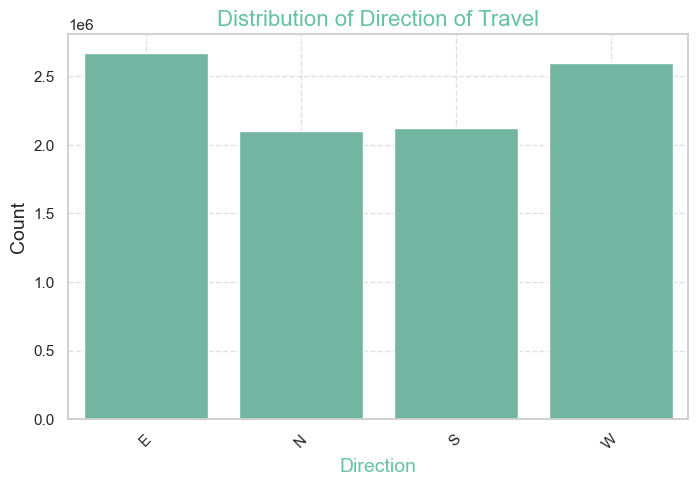

In [74]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Direction of Travel'], color=palette_categorical[0])
plt.title("Distribution of Direction of Travel", fontsize=16, color=palette_categorical[0])
plt.xlabel("Direction", fontsize=14, color=palette_categorical[0])
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The distribution of traffic movement directions is fairly balanced.
The East (E) and West (W) directions have slightly higher counts than North (N) and South (S).
The higher frequency of East-West travel may indicate major highways running in those directions.

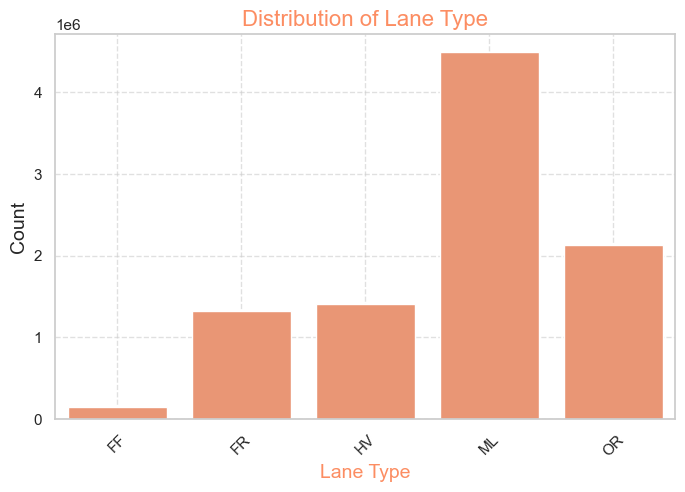

In [75]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Lane Type'], color=palette_categorical[1])
plt.title("Distribution of Lane Type", fontsize=16, color=palette_categorical[1])
plt.xlabel("Lane Type", fontsize=14, color=palette_categorical[1])
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) lanes are the most common, followed by OR (On Ramp), FR (Off Ramp), and HV (High-Occupancy Vehicles).
FF (Freeway-Freeway connectors) are the least common, which makes sense as they are limited to interchanges.
The dominance of Mainline lanes suggests most data is from major roads rather than ramps or special-use lanes.
The distribution of lane types can impact congestion patterns.

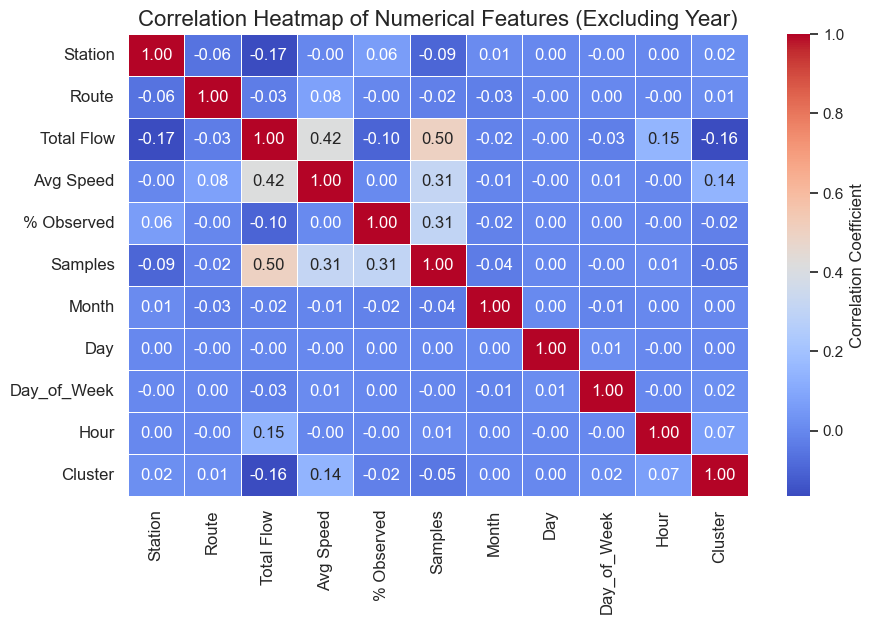

In [97]:
# Select only numerical columns but exclude 'Year'
numeric_df = df.select_dtypes(include=['number']).drop(columns=['Year'], errors='ignore')

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap of Numerical Features (Excluding Year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


The correlation coefficients range from -1 (strong negative) to 1 (strong positive).
Key Observations:
Total Flow and Avg Speed (0.42) → Moderate positive correlation, indicating that as traffic volume increases, speed tends to decrease.
Total Flow and Samples (0.50) → Moderate positive correlation, meaning locations with higher flow also tend to have more data samples.
Hour and Total Flow (0.15) → Weak positive correlation, suggesting a slight increase in flow at specific times of the day.
Cluster values show weak correlations, implying that the clustering process doesn't strongly align with any single feature.
Insights:
The negative correlation between Flow and Speed confirms that higher congestion slows down traffic.
The low correlation between Total Flow and % Observed (-0.10) suggests that missing data does not significantly impact flow measurement.

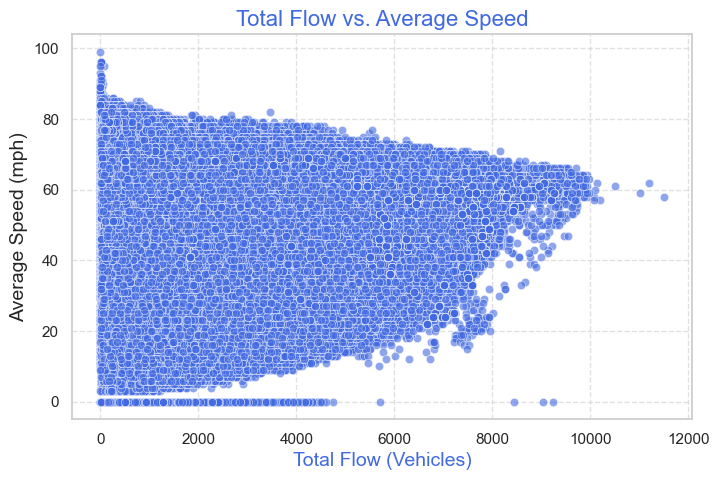

In [87]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'], y=df['Avg Speed'], alpha=0.6, color='royalblue')
plt.title("Total Flow vs. Average Speed", fontsize=16, color='royalblue')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='royalblue')
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Negative trend implies Higher Total Flow is associated with lower Average Speed, confirming congestion effects.
Dense lower-left region thus, many observations have low flow and low speed, possibly representing congested city roads or peak traffic times.
Upper range (10,000 vehicles, 60-80 mph) → Represents high-speed highway conditions with smooth traffic.
This plot visually supports the negative correlation from the heatmap.
Speed dramatically decreases at high flow levels, suggesting potential bottlenecks or highway capacity issues.
Further segmentation by time of day could reveal rush-hour effects.

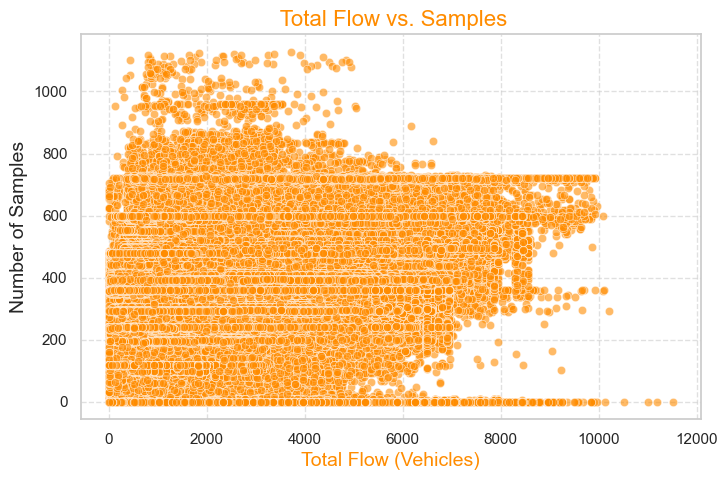

In [123]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'], y=df['Samples'], alpha=0.6, color='darkorange')
plt.title(" Total Flow vs. Samples", fontsize=16, color='darkorange')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='darkorange')
plt.ylabel("Number of Samples", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Strong positive trend implies more samples correspond to higher total flow.
Some stations record very few samples, even at high flow values.
Data distribution is more uniform across flow levels, with a few outliers.
Stations with low sample counts may not accurately reflect traffic conditions.
Ensuring sufficient samples per station is crucial for reliable modeling.
Potential next step: Investigate whether certain road types or time periods have more missing samples.

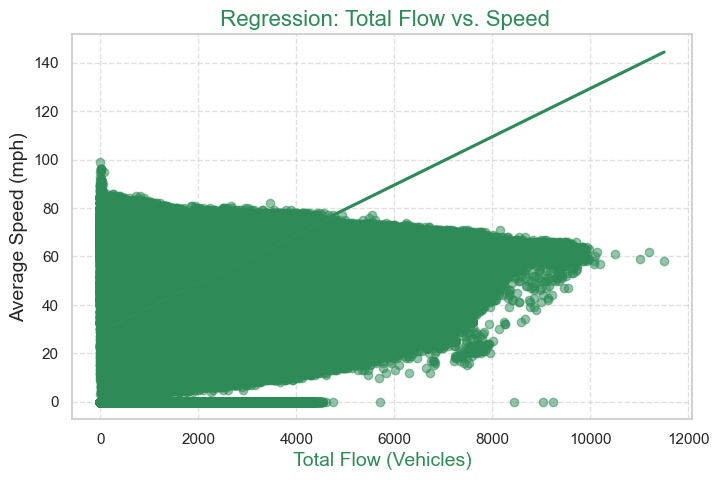

In [89]:
plt.figure(figsize=(8,5))
sns.regplot(x=df['Total Flow'], y=df['Avg Speed'], scatter_kws={'alpha':0.5}, color='seagreen')
plt.title(" Regression: Total Flow vs. Speed", fontsize=16, color='seagreen')
plt.xlabel("Total Flow (Vehicles)", fontsize=14, color='seagreen')
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
The regression line unexpectedly trends upward at high flow values, likely influenced by outliers.
The expected inverse relationship (higher flow → lower speed) is visible in the denser lower-left region.
The top-right extreme points may not follow real-world traffic behavior and require investigation.
Some data points (high flow, high speed) could represent inaccurate sensor readings or low-density highway conditions.

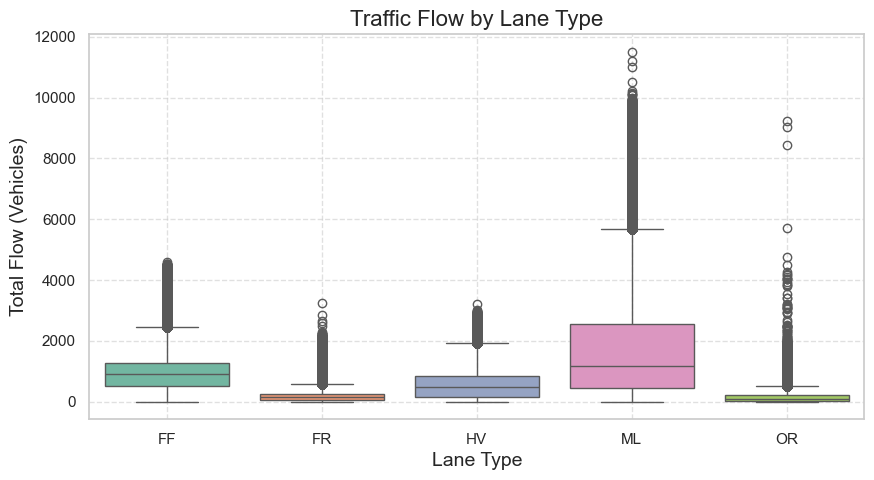

In [108]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Lane Type'], y=df['Total Flow'], hue=df['Lane Type'], palette="Set2")
plt.title("Traffic Flow by Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) lanes have the highest median traffic flow, with significant outliers.
FF (Freeway-Freeway connectors) & HV (High Occupancy Vehicles) have much lower total flow.
High variability in OR (On Ramp) and FR (Off Ramp) lanes, indicating irregular traffic patterns.
Mainline lanes are the primary contributors to congestion.
On-ramps and off-ramps show extreme variations, likely due to different times of day and merging behavior.
A closer look at lane-specific congestion trends could improve forecasting models.

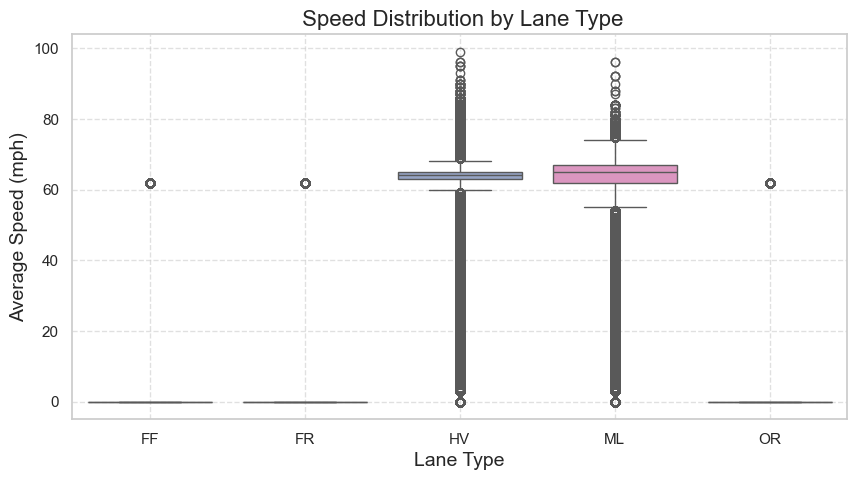

In [109]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Lane Type'], y=df['Avg Speed'], hue=df['Lane Type'], palette="Set2")
plt.title(" Speed Distribution by Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
ML (Mainline) and HV (HOV) lanes have the highest median speeds, suggesting smoother travel conditions.
FF (Freeway-Freeway connectors) have a wide range of speeds, likely due to merging effects.
Some lanes show speeds close to 0, indicating stop-and-go conditions or sensor inaccuracies.
HOV lanes generally perform well, reinforcing their effectiveness.
Low-speed outliers in ML and HV lanes may indicate congestion or incidents.
Further analysis could examine speed trends over time.

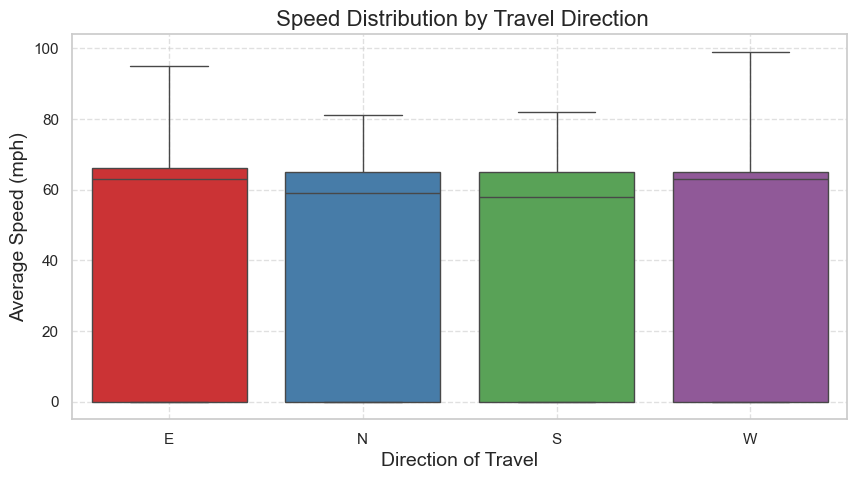

In [110]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Direction of Travel'], y=df['Avg Speed'], hue=df['Direction of Travel'], palette="Set1")
plt.title(" Speed Distribution by Travel Direction", fontsize=16)
plt.xlabel("Direction of Travel", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Speed distribution is relatively consistent across East, West, North, and South.
Westbound (W) travel has slightly higher max speeds, possibly due to highway design.
The presence of low-speed outliers across all directions suggests that traffic slowdowns occur in all directions.
Further exploration is needed to determine if time of day influences these distributions.
If speed patterns are similar across directions, location-specific factors may be more important than directionality.

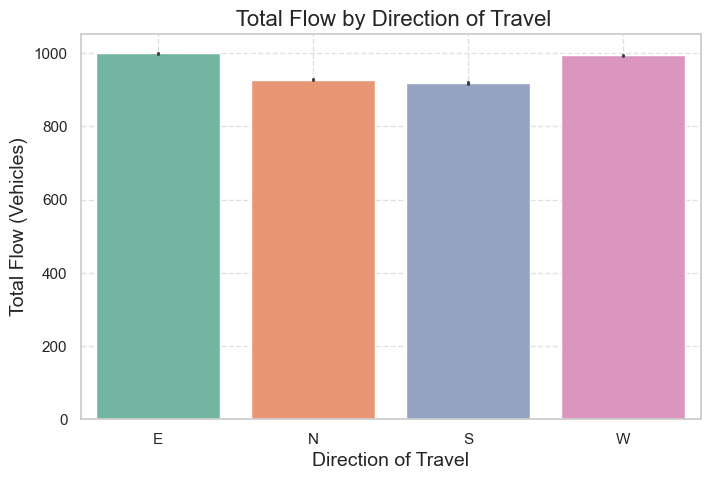

In [113]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Direction of Travel'], y=df['Total Flow'], hue=df['Direction of Travel'], palette="Set2")
plt.title(" Total Flow by Direction of Travel", fontsize=16)
plt.xlabel("Direction of Travel", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Eastbound (E) and Westbound (W) lanes have the highest total flow, suggesting they are primary commuter routes.
Northbound (N) and Southbound (S) lanes have slightly lower flow, possibly due to urban road layouts.
If highway corridors are mostly E-W, infrastructure planning should focus on these routes.
North-South flow could be impacted by intersection delays or fewer major roads.

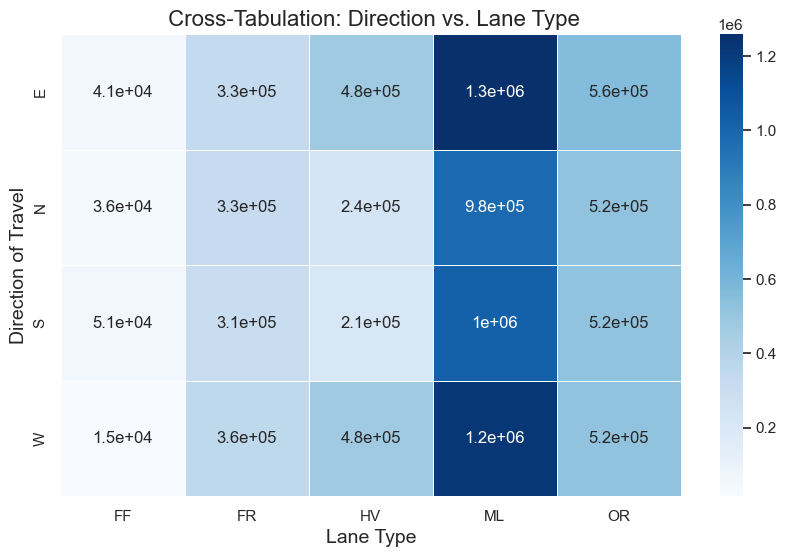

In [77]:
# Compute crosstab
direction_lane_crosstab = pd.crosstab(df['Direction of Travel'], df['Lane Type'])

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(direction_lane_crosstab, annot=True, cmap="Blues", linewidths=0.5)
plt.title(" Cross-Tabulation: Direction vs. Lane Type", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Direction of Travel", fontsize=14)
plt.show()

Interpretation:
Mainline (ML) lanes dominate in all directions, with the highest traffic volume.
HOV lanes have relatively lower use, even on busy roads, which may indicate underutilization.
On-ramps (OR) and Off-ramps (FR) have significant flow in all directions, reinforcing their role in entry/exit.
HOV lane optimization could improve traffic efficiency.

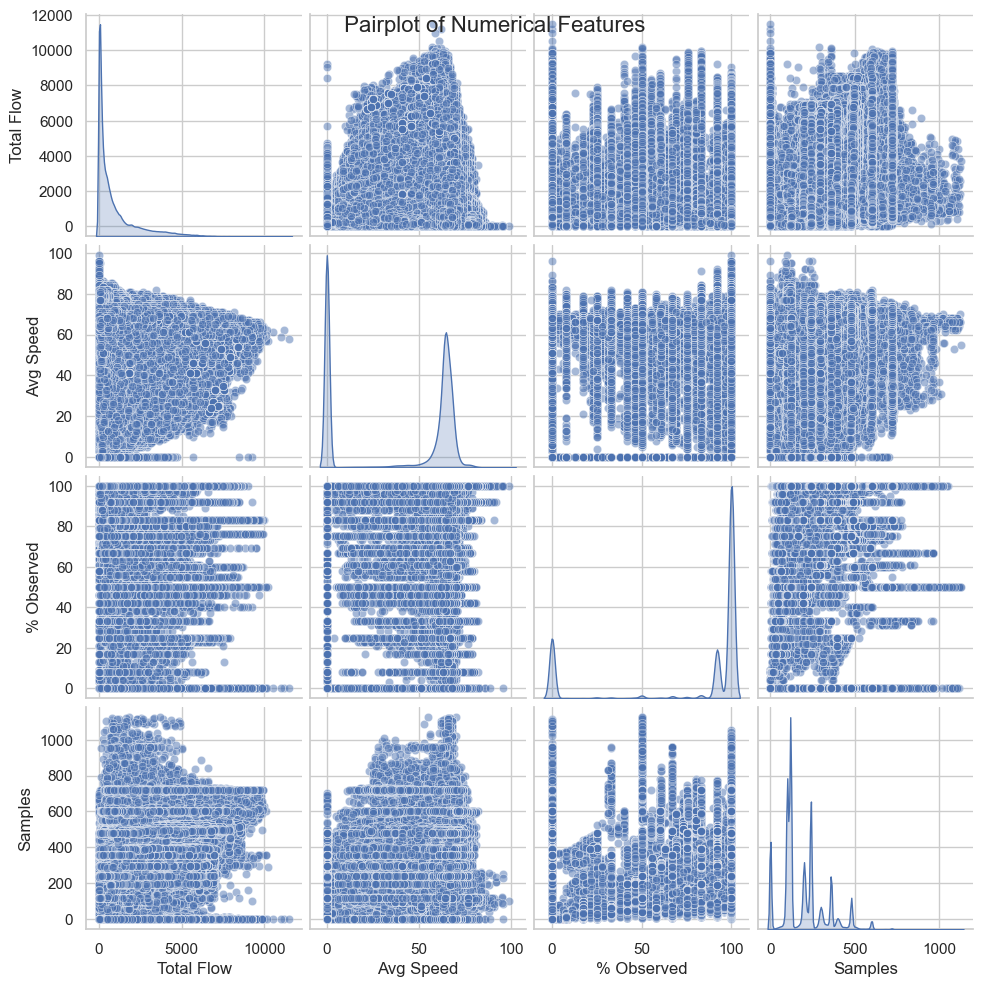

In [91]:
# Select numerical columns for pairplot
numerical_cols = ['Total Flow', 'Avg Speed', '% Observed', 'Samples']

sns.pairplot(df[numerical_cols], diag_kind="kde", plot_kws={"alpha":0.5})
plt.suptitle(" Pairplot of Numerical Features", fontsize=16)
plt.show()

Interpretation:
Clear negative relationship between Flow and Speed.
Bimodal distributions in % Observed suggest data reliability concerns.
Samples appear to be evenly distributed across different features.
The patterns confirm congestion effects, reinforcing the need for predictive modeling.
Some features may require transformation (log scaling) for better model performance.

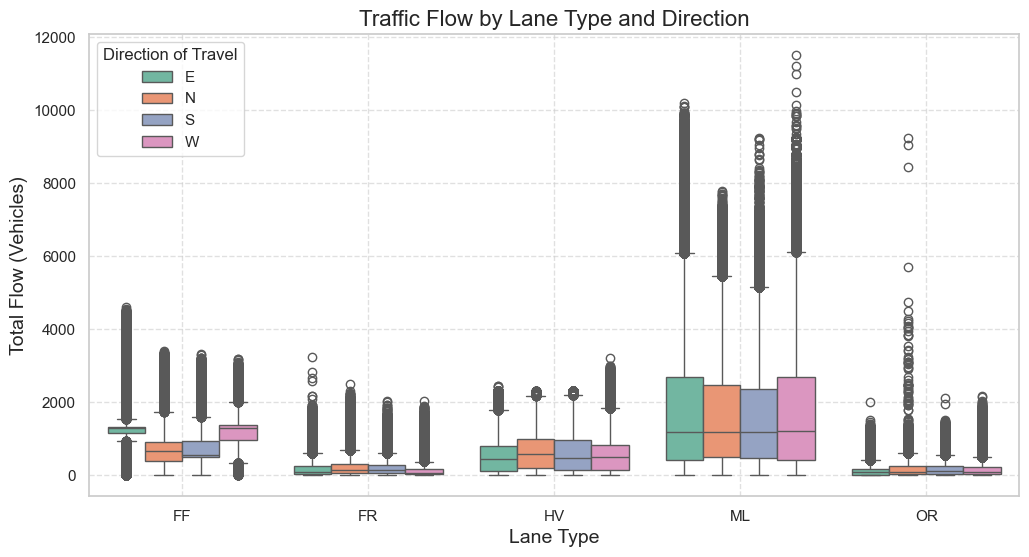

In [92]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Lane Type'], y=df['Total Flow'], hue=df['Direction of Travel'], palette="Set2")
plt.title("Traffic Flow by Lane Type and Direction", fontsize=16)
plt.xlabel("Lane Type", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Direction of Travel")
plt.show()

Interpretation:
Mainline (ML) lanes have the highest traffic flow, across all directions.
Freeway-Freeway connectors (FF) and High-Occupancy Vehicle (HOV) lanes have lower traffic volumes.
On-ramps (OR) and Off-ramps (FR) have lower median flow but exhibit many outliers.
Traffic distribution is fairly consistent across directions (E, N, S, W).
Mainline lanes are the primary sources of congestion.
On-ramps and Off-ramps show a wide range of traffic conditions, likely due to varying merging and exiting behaviors.

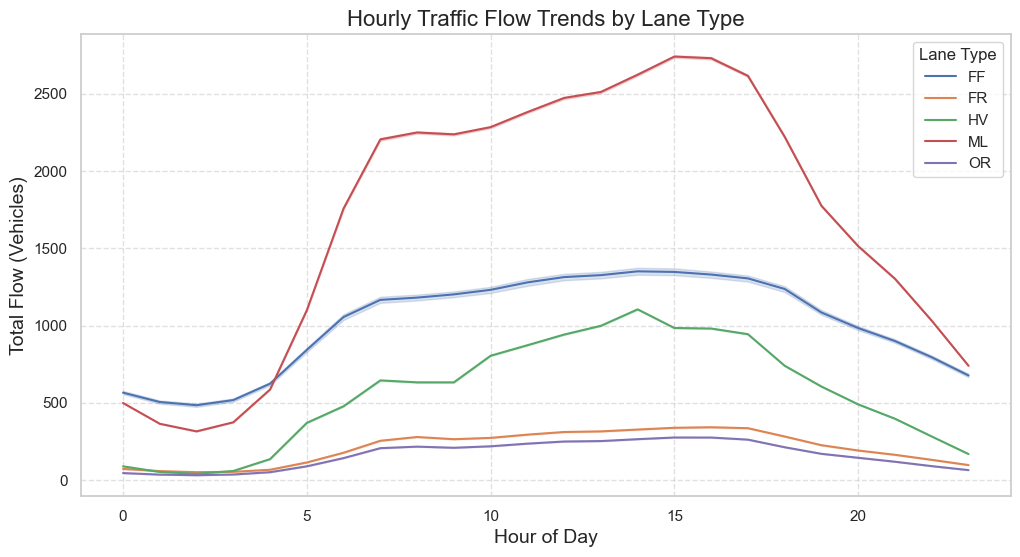

In [114]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['Hour'], y=df['Total Flow'], hue=df['Lane Type'])
plt.title("Hourly Traffic Flow Trends by Lane Type", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Total Flow (Vehicles)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretation:
Morning peak (6 AM - 9 AM) and evening peak (3 PM - 6 PM) are clearly visible.
Mainline (ML) lanes experience the highest congestion, while on/off ramps see lower but steady flow.
HOV lanes show a steady increase and peak in the afternoon.
Rush hour effects are significant and should be modeled in time-series forecasting.
HOV lanes increase during peak hours, suggesting effective usage by commuters.

In [100]:
df.columns = df.columns.str.strip()

In [101]:
# Selecting relevant features for clustering
X = df[['Total Flow', 'Avg Speed']].dropna()

# Convert to numeric 
X = X.apply(pd.to_numeric, errors='coerce')

# Run KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

print(df['Cluster'].value_counts())  # Verify cluster assignments


Cluster
1    6894357
2    1810324
0     791294
Name: count, dtype: int64


In [118]:
# Suppress legend performance warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

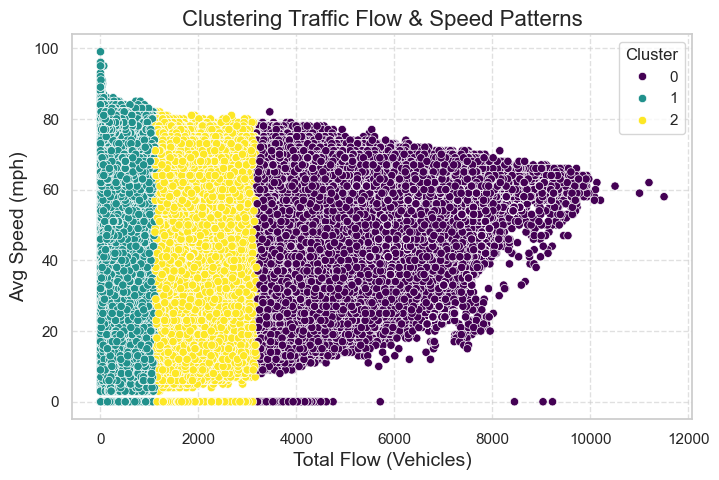

In [119]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Total Flow'].astype(float), y=df['Avg Speed'].astype(float), hue=df['Cluster'], palette='viridis')
plt.title("Clustering Traffic Flow & Speed Patterns", fontsize=16)
plt.xlabel("Total Flow (Vehicles)", fontsize=14)
plt.ylabel("Avg Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Three distinct clusters are identified:
Cluster 0 (Purple): High flow, low speed → Likely congested highways.
Cluster 1 (Green): Low flow, varying speed → Could be minor roads or off-peak traffic.
Cluster 2 (Yellow): Moderate flow, moderate speed → Normal operational roads.
Traffic conditions can be grouped into meaningful categories.
High-traffic, low-speed regions require congestion management strategies.

<Figure size 1000x500 with 0 Axes>

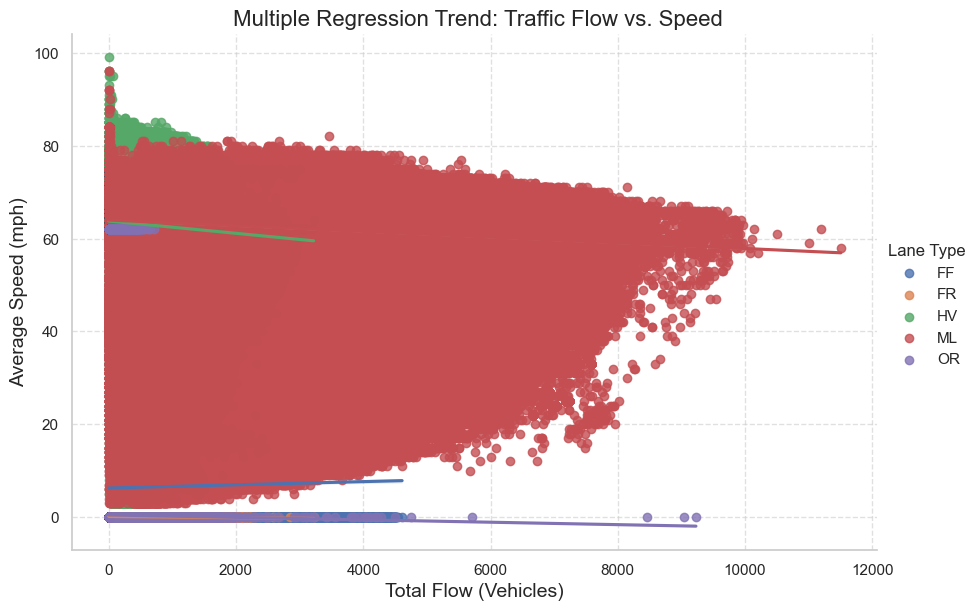

In [98]:
plt.figure(figsize=(10,5))
sns.lmplot(x='Total Flow', y='Avg Speed', hue='Lane Type', data=df, height=6, aspect=1.5)
plt.title(" Multiple Regression Trend: Traffic Flow vs. Speed", fontsize=16)
plt.xlabel("Total Flow (Vehicles)", fontsize=14)
plt.ylabel("Average Speed (mph)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
Mainline lanes dominate the traffic dataset, as shown by the red points.
As flow increases, speed generally decreases, confirming congestion effects.
HOV lanes show slightly higher speeds at similar traffic volumes.
Regression confirms negative speed-flow relationship.
Certain lane types (HOV) perform better than others, highlighting potential traffic management strategies.

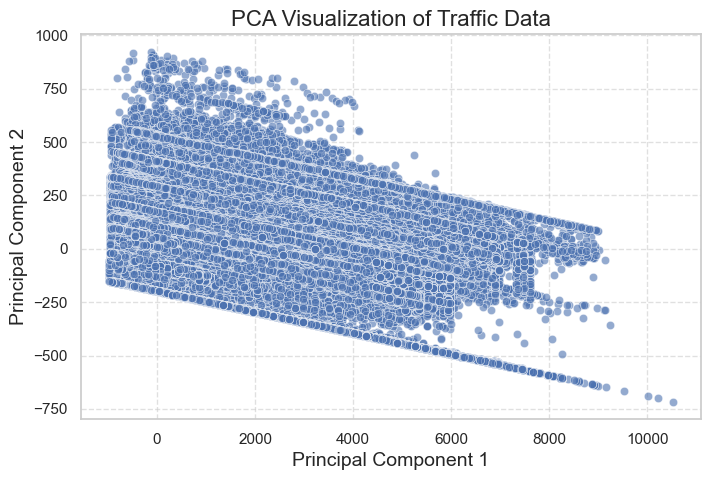

In [104]:
# Selecting numerical columns for PCA
X_pca = df[['Total Flow', 'Avg Speed', '% Observed', 'Samples']].dropna()

# Applying PCA
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_pca)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca_transformed, columns=["PC1", "PC2"])

plt.figure(figsize=(8,5))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], alpha=0.6)
plt.title("PCA Visualization of Traffic Data", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Interpretation:
The first two Principal Components (PCs) explain the majority of variance in the dataset.
Data follows a downward diagonal trend, suggesting strong underlying relationships between features.
The spread of data along PC1 suggests it captures major variations in traffic conditions.
Dimensionality reduction helps visualize patterns in traffic data.

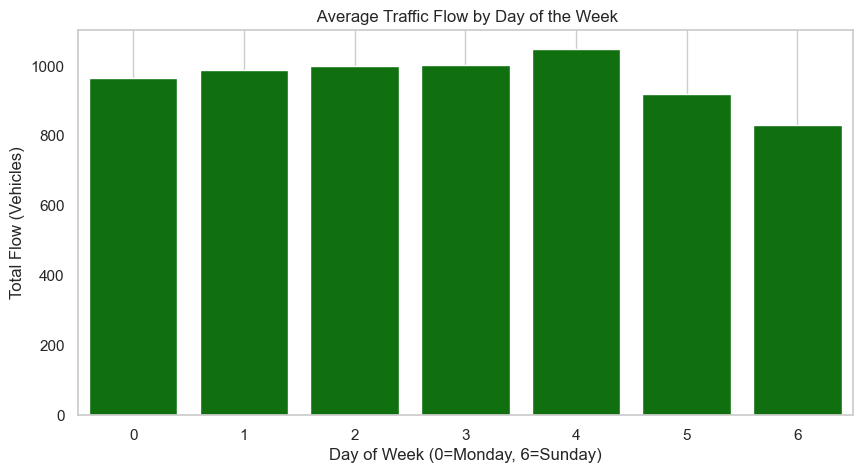

In [106]:
# Group by Day of Week
weekday_flow = df.groupby('Day_of_Week')['Total Flow'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=weekday_flow.index, y=weekday_flow.values, color = "green")
plt.title(" Average Traffic Flow by Day of the Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Flow (Vehicles)")
plt.grid()
plt.show()


Interpretation:
Weekdays (Monday - Friday) have higher traffic volumes, peaking on Friday.
Traffic drops on weekends, especially on Sundays.
Work-week trends are clear, confirming a strong weekday commuting pattern.
Weekend traffic is lower, suggesting different mobility patterns.

## Feature Engineering

In [193]:
# One-Hot Encode categorical variables
df = pd.get_dummies(df, columns=['Lane Type', 'Direction of Travel'], drop_first=True).astype('int64')

In [194]:
# Convert timestamp from nanoseconds to proper datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ns')

In [195]:
df.head()

Timestamp  Station  Route  Total Flow  Avg Speed  % Observed  Samples  \
0 2024-06-01   308512     50         598         63           0      195   
1 2024-06-01   311831      5          39          0         100      108   
2 2024-06-01   311832      5           0          0         100      108   
3 2024-06-01   311844      5         107          0         100      216   
4 2024-06-01   311847      5         101          0         100      324   

   Year  Month  Day  Day_of_Week  Hour  Lane Type_FR  Lane Type_HV  \
0  2024      6    1            5     0             0             0   
1  2024      6    1            5     0             0             0   
2  2024      6    1            5     0             1             0   
3  2024      6    1            5     0             0             0   
4  2024      6    1            5     0             0             0   

   Lane Type_ML  Lane Type_OR  Direction of Travel_N  Direction of Travel_S  \
0             1             0                      0                      0   
1             0             1                      0                      1   
2             0             0                      0                      1   
3             0             1                      1                      0   
4             0             1                      1                      0   

   Direction of Travel_W  
0                      1  
1                      0  
2                      0  
3                      0  
4                      0

## **Feature Engineering Steps**
Before applying any models, we need to transform our dataset:

### **1. Drop Unnecessary Features**
- Remove **'Avg Speed'** since it's not needed in our analysis.

### **2. Generate Lag Features**
- These features help capture past values of **'Total Flow'** to improve forecasting.
- Example: `Total Flow t-1` represents **Total Flow from the previous hour**.
- We will create lags up to **7 previous time steps**.

### **3. Compute Rolling Statistics**
- Rolling statistics smooth fluctuations and help models recognize trends.
- We will compute the following over a **7-day window**:
  - **Rolling Mean** (captures trend)
  - **Rolling Standard Deviation** (captures variability)
  - **Rolling Min & Max** (captures extremes)

### **4. Cyclical Encoding of Time Features**
- Since time variables like **hour, day, and month** have cyclical patterns (e.g., 24-hour cycle, weekly traffic trends), we apply **sine and cosine transformations**.
- This ensures that the model correctly interprets time-based periodicity.

### **5. Compute Coefficient of Variation (CV) for Clustering**
- CV helps measure variability in `Total Flow` for each **station**.
- Used to **group similar stations/routes** based on traffic pattern consistency.
- **Formula:** \( CV = \frac{\text{Standard Deviation}}{\text{Mean}} \)

In [196]:
# Drop 'Avg Speed' using .loc
df = df.loc[:, df.columns != 'Avg Speed']

# Verify changes
print("Columns after dropping 'Avg Speed':", df.columns)

Columns after dropping 'Avg Speed': Index(['Timestamp', 'Station', 'Route', 'Total Flow', '% Observed', 'Samples',
       'Year', 'Month', 'Day', 'Day_of_Week', 'Hour', 'Lane Type_FR',
       'Lane Type_HV', 'Lane Type_ML', 'Lane Type_OR', 'Direction of Travel_N',
       'Direction of Travel_S', 'Direction of Travel_W'],
      dtype='object')


In [197]:
# Create lag features for past 7 time steps
for lag in range(1, 8):  
    df[f'Total Flow t-{lag}'] = df['Total Flow'].shift(lag)

# Verify
df.head(10)  # Check first 10 rows

Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   308512     50         598           0      195  2024      6   
1 2024-06-01   311831      5          39         100      108  2024      6   
2 2024-06-01   311832      5           0         100      108  2024      6   
3 2024-06-01   311844      5         107         100      216  2024      6   
4 2024-06-01   311847      5         101         100      324  2024      6   
5 2024-06-01   311864      5         142           0      108  2024      6   
6 2024-06-01   311903     50         893           0      324  2024      6   
7 2024-06-01   311930     50         964         100      322  2024      6   
8 2024-06-01   311973     50           1         100      108  2024      6   
9 2024-06-01   311974     50        1765           0      432  2024      6   

   Day  Day_of_Week  ...  Direction of Travel_N  Direction of Travel_S  \
0    1            5  ...                      0                      0   
1    1            5  ...                      0                      1   
2    1            5  ...                      0                      1   
3    1            5  ...                      1                      0   
4    1            5  ...                      1                      0   
5    1            5  ...                      1                      0   
6    1            5  ...                      0                      0   
7    1            5  ...                      0                      0   
8    1            5  ...                      0                      0   
9    1            5  ...                      0                      0   

   Direction of Travel_W  Total Flow t-1  Total Flow t-2  Total Flow t-3  \
0                      1             NaN             NaN             NaN   
1                      0           598.0             NaN             NaN   
2                      0            39.0           598.0             NaN   
3                      0             0.0            39.0           598.0   
4                      0           107.0             0.0            39.0   
5                      0           101.0           107.0             0.0   
6                      0           142.0           101.0           107.0   
7                      0           893.0           142.0           101.0   
8                      0           964.0           893.0           142.0   
9                      0             1.0           964.0           893.0   

   Total Flow t-4  Total Flow t-5  Total Flow t-6  Total Flow t-7  
0             NaN             NaN             NaN             NaN  
1             NaN             NaN             NaN             NaN  
2             NaN             NaN             NaN             NaN  
3             NaN             NaN             NaN             NaN  
4           598.0             NaN             NaN             NaN  
5            39.0           598.0             NaN             NaN  
6             0.0            39.0           598.0             NaN  
7           107.0             0.0            39.0           598.0  
8           101.0           107.0             0.0            39.0  
9           142.0           101.0           107.0             0.0  

[10 rows x 25 columns]

In [198]:
# Drop first 7 rows since they contain NaNs due to lag features
df = df.iloc[7:].reset_index(drop=True)

# Verify
print("Shape after dropping NaNs from lags:", df.shape)
df.head(10)

Shape after dropping NaNs from lags: (9495968, 25)


Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   311930     50         964         100      322  2024      6   
1 2024-06-01   311973     50           1         100      108  2024      6   
2 2024-06-01   311974     50        1765           0      432  2024      6   
3 2024-06-01   312009     50           0         100      216  2024      6   
4 2024-06-01   312010     50        1765           0        0  2024      6   
5 2024-06-01   312011     50          81           0      216  2024      6   
6 2024-06-01   312012     50         168           0      108  2024      6   
7 2024-06-01   312098     50        1296          25      432  2024      6   
8 2024-06-01   312099     50          47         100      108  2024      6   
9 2024-06-01   312103     50        1580           0        0  2024      6   

   Day  Day_of_Week  ...  Direction of Travel_N  Direction of Travel_S  \
0    1            5  ...                      0                      0   
1    1            5  ...                      0                      0   
2    1            5  ...                      0                      0   
3    1            5  ...                      0                      0   
4    1            5  ...                      0                      0   
5    1            5  ...                      0                      0   
6    1            5  ...                      0                      0   
7    1            5  ...                      0                      0   
8    1            5  ...                      0                      0   
9    1            5  ...                      0                      0   

   Direction of Travel_W  Total Flow t-1  Total Flow t-2  Total Flow t-3  \
0                      0           893.0           142.0           101.0   
1                      0           964.0           893.0           142.0   
2                      0             1.0           964.0           893.0   
3                      0          1765.0             1.0           964.0   
4                      1             0.0          1765.0             1.0   
5                      1          1765.0             0.0          1765.0   
6                      1            81.0          1765.0             0.0   
7                      0           168.0            81.0          1765.0   
8                      0          1296.0           168.0            81.0   
9                      1            47.0          1296.0           168.0   

   Total Flow t-4  Total Flow t-5  Total Flow t-6  Total Flow t-7  
0           107.0             0.0            39.0           598.0  
1           101.0           107.0             0.0            39.0  
2           142.0           101.0           107.0             0.0  
3           893.0           142.0           101.0           107.0  
4           964.0           893.0           142.0           101.0  
5             1.0           964.0           893.0           142.0  
6          1765.0             1.0           964.0           893.0  
7             0.0          1765.0             1.0           964.0  
8          1765.0             0.0          1765.0             1.0  
9            81.0          1765.0             0.0          1765.0  

[10 rows x 25 columns]

In [200]:
# Rolling statistics over a 24-hour window (short-term trend)
df['Rolling Mean (24h)'] = df['Total Flow'].rolling(window=24).mean()
df['Rolling Std (24h)'] = df['Total Flow'].rolling(window=24).std()
df['Rolling Min (24h)'] = df['Total Flow'].rolling(window=24).min()
df['Rolling Max (24h)'] = df['Total Flow'].rolling(window=24).max()

# Rolling statistics over a 168-hour window (weekly trend)
df['Rolling Mean (7d)'] = df['Total Flow'].rolling(window=168).mean()
df['Rolling Std (7d)'] = df['Total Flow'].rolling(window=168).std()
df['Rolling Min (7d)'] = df['Total Flow'].rolling(window=168).min()
df['Rolling Max (7d)'] = df['Total Flow'].rolling(window=168).max()

Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0  2024-06-01   311930     50         964         100      322  2024      6   
1  2024-06-01   311973     50           1         100      108  2024      6   
2  2024-06-01   311974     50        1765           0      432  2024      6   
3  2024-06-01   312009     50           0         100      216  2024      6   
4  2024-06-01   312010     50        1765           0        0  2024      6   
5  2024-06-01   312011     50          81           0      216  2024      6   
6  2024-06-01   312012     50         168           0      108  2024      6   
7  2024-06-01   312098     50        1296          25      432  2024      6   
8  2024-06-01   312099     50          47         100      108  2024      6   
9  2024-06-01   312103     50        1580           0        0  2024      6   
10 2024-06-01   312104     50          81           0        0  2024      6   
11 2024-06-01   312105     50         168           0        0  2024      6   
12 2024-06-01   312108     50           0         100      108  2024      6   
13 2024-06-01   312132      5         477         100      214  2024      6   
14 2024-06-01   312133      5         552         100      322  2024      6   
15 2024-06-01   312134      5         489         100      216  2024      6   
16 2024-06-01   312139     50        1765           0      540  2024      6   
17 2024-06-01   312141     50         277          50      216  2024      6   
18 2024-06-01   312142     50           0         100      216  2024      6   
19 2024-06-01   312188     50        1368           0        0  2024      6   
20 2024-06-01   312189     50          81           0        0  2024      6   
21 2024-06-01   312233     99         953         100      324  2024      6   
22 2024-06-01   312236     50        1580           0        0  2024      6   
23 2024-06-01   312247     50          81           0        0  2024      6   
24 2024-06-01   312264     50        1185           0      432  2024      6   
25 2024-06-01   312265     50          66          33      324  2024      6   
26 2024-06-01   312326     80         838         100      432  2024      6   
27 2024-06-01   312327     80         161         100      216  2024      6   
28 2024-06-01   312343     80        1097         100      323  2024      6   
29 2024-06-01   312344     80          91         100      216  2024      6   

    Day  Day_of_Week  ...  Total Flow t-6  Total Flow t-7  Rolling Mean (24h)  \
0     1            5  ...            39.0           598.0                 NaN   
1     1            5  ...             0.0            39.0                 NaN   
2     1            5  ...           107.0             0.0                 NaN   
3     1            5  ...           101.0           107.0                 NaN   
4     1            5  ...           142.0           101.0                 NaN   
5     1            5  ...           893.0           142.0                 NaN   
6     1            5  ...           964.0           893.0                 NaN   
7     1            5  ...             1.0           964.0                 NaN   
8     1            5  ...          1765.0             1.0                 NaN   
9     1            5  ...             0.0          1765.0                 NaN   
10    1            5  ...          1765.0             0.0                 NaN   
11    1            5  ...            81.0          1765.0                 NaN   
12    1            5  ...           168.0            81.0                 NaN   
13    1            5  ...          1296.0           168.0                 NaN   
14    1            5  ...            47.0          1296.0                 NaN   
15    1            5  ...          1580.0            47.0                 NaN   
16    1            5  ...            81.0          1580.0                 NaN   
17    1            5  ...           168.0            81.0                 NaN   
18    1        

In [201]:
df.head(120)

Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0   2024-06-01   311930     50         964         100      322  2024      6   
1   2024-06-01   311973     50           1         100      108  2024      6   
2   2024-06-01   311974     50        1765           0      432  2024      6   
3   2024-06-01   312009     50           0         100      216  2024      6   
4   2024-06-01   312010     50        1765           0        0  2024      6   
..         ...      ...    ...         ...         ...      ...   ...    ...   
115 2024-06-01   313002     50         168           0      108  2024      6   
116 2024-06-01   313003     50         744         100      432  2024      6   
117 2024-06-01   313004     50          80         100      108  2024      6   
118 2024-06-01   313005     50         659         100      432  2024      6   
119 2024-06-01   313006     50          43         100      108  2024      6   

     Day  Day_of_Week  ...  Total Flow t-6  Total Flow t-7  \
0      1            5  ...            39.0           598.0   
1      1            5  ...             0.0            39.0   
2      1            5  ...           107.0             0.0   
3      1            5  ...           101.0           107.0   
4      1            5  ...           142.0           101.0   
..   ...          ...  ...             ...             ...   
115    1            5  ...          1117.0            31.0   
116    1            5  ...            12.0          1117.0   
117    1            5  ...           982.0            12.0   
118    1            5  ...           108.0           982.0   
119    1            5  ...          1811.0           108.0   

     Rolling Mean (24h)  Rolling Std (24h)  Rolling Min (24h)  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   
..                  ...                ...                ...   
115          886.041667         987.411129               11.0   
116          869.208333         986.194045               11.0   
117          867.875000         987.283331               11.0   
118          844.208333         985.105776               11.0   
119          783.958333         988.169695               11.0   

     Rolling Max (24h)  Rolling Mean (7d)  Rolling Std (7d)  Rolling Min (7d)  \
0                  NaN                NaN               NaN               NaN   
1                  NaN                NaN               NaN               NaN   
2                  NaN                NaN               NaN               NaN   
3                  NaN                NaN               NaN               NaN   
4                  NaN                NaN               NaN               NaN   
..                 ...                ...               ...               ...   
115             4128.0                NaN               NaN               NaN   
116             4128.0                NaN               NaN               NaN   
117             4128.0                NaN               NaN               NaN   
118             4128.0                NaN               NaN               NaN   
119             4128.0                NaN               NaN               NaN   

     Rolling Max (7d)  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
..                ...  
115               NaN  
116               NaN  
117               NaN  
118               NaN  
119               NaN  

[120 rows x 33 columns]

In [202]:
# Drop rows with NaNs in rolling features
df = df.dropna().reset_index(drop=True)

df.head(10)


Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   313468     80        1207         100      432  2024      6   
1 2024-06-01   313469     80        1198         100      432  2024      6   
2 2024-06-01   313475     80        1110         100      432  2024      6   
3 2024-06-01   313482     80        1181         100      432  2024      6   
4 2024-06-01   313487     80         887         100      324  2024      6   
5 2024-06-01   313493     80        1418           0        0  2024      6   
6 2024-06-01   313512     80        1058           0        0  2024      6   
7 2024-06-01   313551     50         359         100      215  2024      6   
8 2024-06-01   313552     50         373         100      216  2024      6   
9 2024-06-01   313560     80        1288         100      432  2024      6   

   Day  Day_of_Week  ...  Total Flow t-6  Total Flow t-7  Rolling Mean (24h)  \
0    1            5  ...          1112.0          1343.0         1065.708333   
1    1            5  ...          1337.0          1112.0         1077.333333   
2    1            5  ...          1176.0          1337.0         1079.125000   
3    1            5  ...           954.0          1176.0         1074.666667   
4    1            5  ...          1120.0           954.0         1068.458333   
5    1            5  ...           970.0          1120.0         1094.166667   
6    1            5  ...          1207.0           970.0         1089.125000   
7    1            5  ...          1198.0          1207.0         1060.000000   
8    1            5  ...          1110.0          1198.0         1055.875000   
9    1            5  ...          1181.0          1110.0         1090.750000   

   Rolling Std (24h)  Rolling Min (24h)  Rolling Max (24h)  Rolling Mean (7d)  \
0         393.936706              150.0             1716.0         691.136905   
1         393.535554              150.0             1716.0         692.529762   
2         393.584344              150.0             1716.0         699.130952   
3         391.717030              150.0             1716.0         695.654762   
4         393.533047              150.0             1716.0         700.934524   
5         395.449845              150.0             1716.0         698.869048   
6         395.092429              150.0             1716.0         704.684524   
7         422.312989              150.0             1716.0         705.821429   
8         428.740655              150.0             1716.0         700.327381   
9         411.077296              150.0             1716.0         707.714286   

   Rolling Std (7d)  Rolling Min (7d)  Rolling Max (7d)  
0        654.676479               0.0            4128.0  
1        655.508880               0.0            4128.0  
2        654.085700               0.0            4128.0  
3        649.925763               0.0            4128.0  
4        647.840162               0.0            4128.0  
5        644.974163               0.0            4128.0  
6        643.773216               0.0            4128.0  
7        642.987929               0.0            4128.0  
8        641.857237               0.0            4128.0  
9        641.434276               0.0            4128.0  

[10 rows x 33 columns]

In [203]:
# Encode hour (24-hour cycle)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Encode day of the week (7-day cycle)
df['Day_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['Day_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

# Encode month (12-month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [204]:
# Verify
df.head(10)

Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   313468     80        1207         100      432  2024      6   
1 2024-06-01   313469     80        1198         100      432  2024      6   
2 2024-06-01   313475     80        1110         100      432  2024      6   
3 2024-06-01   313482     80        1181         100      432  2024      6   
4 2024-06-01   313487     80         887         100      324  2024      6   
5 2024-06-01   313493     80        1418           0        0  2024      6   
6 2024-06-01   313512     80        1058           0        0  2024      6   
7 2024-06-01   313551     50         359         100      215  2024      6   
8 2024-06-01   313552     50         373         100      216  2024      6   
9 2024-06-01   313560     80        1288         100      432  2024      6   

   Day  Day_of_Week  ...  Rolling Mean (7d)  Rolling Std (7d)  \
0    1            5  ...         691.136905        654.676479   
1    1            5  ...         692.529762        655.508880   
2    1            5  ...         699.130952        654.085700   
3    1            5  ...         695.654762        649.925763   
4    1            5  ...         700.934524        647.840162   
5    1            5  ...         698.869048        644.974163   
6    1            5  ...         704.684524        643.773216   
7    1            5  ...         705.821429        642.987929   
8    1            5  ...         700.327381        641.857237   
9    1            5  ...         707.714286        641.434276   

   Rolling Min (7d)  Rolling Max (7d)  Hour_sin  Hour_cos   Day_sin   Day_cos  \
0               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
1               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
2               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
3               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
4               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
5               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
6               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
7               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
8               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   
9               0.0            4128.0       0.0       1.0 -0.974928 -0.222521   

      Month_sin  Month_cos  
0  1.224647e-16       -1.0  
1  1.224647e-16       -1.0  
2  1.224647e-16       -1.0  
3  1.224647e-16       -1.0  
4  1.224647e-16       -1.0  
5  1.224647e-16       -1.0  
6  1.224647e-16       -1.0  
7  1.224647e-16       -1.0  
8  1.224647e-16       -1.0  
9  1.224647e-16       -1.0  

[10 rows x 39 columns]

In [213]:
# Compute mean and standard deviation per (Station, Route)
df_grouped = df.groupby(["Station", "Route"])["Total Flow"].agg(['mean', 'std'])
df_grouped["CV"] = df_grouped["std"] / df_grouped["mean"]

# Merge back into main dataset
df = df.merge(df_grouped[["CV"]], on=["Station", "Route"], how="left")

In [214]:
# Compute rolling CV over the past 24 hours
df['Rolling_CV'] = df['Total Flow'].rolling(window=24).std() / df['Total Flow'].rolling(window=24).mean()

In [215]:
df.head(10)

Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   313931     50        1033           0        0  2024      6   
1 2024-06-01   313938     50        1580           0        0  2024      6   
2 2024-06-01   313951     51        1385           0        0  2024      6   
3 2024-06-01   313956     51         710         100      322  2024      6   
4 2024-06-01   313965     51         125         100      108  2024      6   
5 2024-06-01   313979     80         673         100      324  2024      6   
6 2024-06-01   313980     80          74         100      216  2024      6   
7 2024-06-01   313981     80         144         100      216  2024      6   
8 2024-06-01   314000     80         237         100      324  2024      6   
9 2024-06-01   314001     80         203         100      216  2024      6   

   Day  Day_of_Week  ...  Rolling Max (7d)  Hour_sin  Hour_cos   Day_sin  \
0    1            5  ...            4128.0       0.0       1.0 -0.974928   
1    1            5  ...            4128.0       0.0       1.0 -0.974928   
2    1            5  ...            4128.0       0.0       1.0 -0.974928   
3    1            5  ...            4128.0       0.0       1.0 -0.974928   
4    1            5  ...            4128.0       0.0       1.0 -0.974928   
5    1            5  ...            4128.0       0.0       1.0 -0.974928   
6    1            5  ...            4128.0       0.0       1.0 -0.974928   
7    1            5  ...            4128.0       0.0       1.0 -0.974928   
8    1            5  ...            4128.0       0.0       1.0 -0.974928   
9    1            5  ...            4128.0       0.0       1.0 -0.974928   

    Day_cos     Month_sin  Month_cos      CV_x  Rolling_CV      CV_y  
0 -0.222521  1.224647e-16       -1.0  0.529579         NaN  0.529579  
1 -0.222521  1.224647e-16       -1.0  0.523989         NaN  0.523989  
2 -0.222521  1.224647e-16       -1.0  0.531718         NaN  0.531718  
3 -0.222521  1.224647e-16       -1.0  0.499469         NaN  0.499469  
4 -0.222521  1.224647e-16       -1.0  0.637886         NaN  0.637886  
5 -0.222521  1.224647e-16       -1.0  0.531564         NaN  0.531564  
6 -0.222521  1.224647e-16       -1.0  0.695915         NaN  0.695915  
7 -0.222521  1.224647e-16       -1.0  0.641120         NaN  0.641120  
8 -0.222521  1.224647e-16       -1.0  0.668733         NaN  0.668733  
9 -0.222521  1.224647e-16       -1.0  0.750293         NaN  0.750293  

[10 rows x 42 columns]

In [216]:
# Drop NaNs in Rolling CV
df = df.dropna(subset=['Rolling_CV']).reset_index(drop=True)

# Verify
print("Shape after dropping NaNs:", df.shape)
df.head(10)

Shape after dropping NaNs: (9495755, 42)


Timestamp  Station  Route  Total Flow  % Observed  Samples  Year  Month  \
0 2024-06-01   314114     99         124         100      108  2024      6   
1 2024-06-01   314115     99          66         100      216  2024      6   
2 2024-06-01   314121     51        1578           0      324  2024      6   
3 2024-06-01   314129     51         194           0        0  2024      6   
4 2024-06-01   314131     51         236           0        0  2024      6   
5 2024-06-01   314138     51          79         100      108  2024      6   
6 2024-06-01   314145     51         236           0      216  2024      6   
7 2024-06-01   314147     51        1020         100      216  2024      6   
8 2024-06-01   314157     51        1042          98      316  2024      6   
9 2024-06-01   314159    160         139         100      177  2024      6   

   Day  Day_of_Week  ...  Rolling Max (7d)  Hour_sin  Hour_cos   Day_sin  \
0    1            5  ...            4128.0       0.0       1.0 -0.974928   
1    1            5  ...            4128.0       0.0       1.0 -0.974928   
2    1            5  ...            4128.0       0.0       1.0 -0.974928   
3    1            5  ...            4128.0       0.0       1.0 -0.974928   
4    1            5  ...            4128.0       0.0       1.0 -0.974928   
5    1            5  ...            4128.0       0.0       1.0 -0.974928   
6    1            5  ...            4128.0       0.0       1.0 -0.974928   
7    1            5  ...            4128.0       0.0       1.0 -0.974928   
8    1            5  ...            4128.0       0.0       1.0 -0.974928   
9    1            5  ...            4128.0       0.0       1.0 -0.974928   

    Day_cos     Month_sin  Month_cos      CV_x  Rolling_CV      CV_y  
0 -0.222521  1.224647e-16       -1.0  0.629532    1.093147  0.629532  
1 -0.222521  1.224647e-16       -1.0  0.705035    1.173432  0.705035  
2 -0.222521  1.224647e-16       -1.0  0.521549    1.173096  0.521549  
3 -0.222521  1.224647e-16       -1.0  0.411320    1.192750  0.411320  
4 -0.222521  1.224647e-16       -1.0  0.359206    1.243262  0.359206  
5 -0.222521  1.224647e-16       -1.0  0.636564    1.254238  0.636564  
6 -0.222521  1.224647e-16       -1.0  0.000000    1.306955  0.000000  
7 -0.222521  1.224647e-16       -1.0  0.364782    1.223974  0.364782  
8 -0.222521  1.224647e-16       -1.0  0.566221    1.160030  0.566221  
9 -0.222521  1.224647e-16       -1.0  0.751109    1.177684  0.751109  

[10 rows x 42 columns]

In [219]:
# Drop CV_x and rename CV_y as CV using .loc
df = df.loc[:, ~df.columns.isin(['CV_x'])]  # Drop 'CV_x'
df = df.rename(columns={'CV_y': 'CV'})  # Rename 'CV_y' to 'CV'

In [220]:
# Select features for clustering
clustering_features = ['CV', 'Rolling_CV']

# Extract unique (Station, Route) combinations for clustering
df_cluster = df.groupby(["Station", "Route"])[clustering_features].mean().dropna()

# Verify data
print(df_cluster.head())

                     CV  Rolling_CV
Station Route                      
308511  50     0.794475    1.299773
308512  50     0.432043    1.237890
311831  5      0.866402    1.251200
311832  5      0.603807    1.250586
311844  5      0.679335    1.249487


In [221]:
wcss = []  # Within-cluster sum of squares
K_range = range(2, 10)  # Test k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

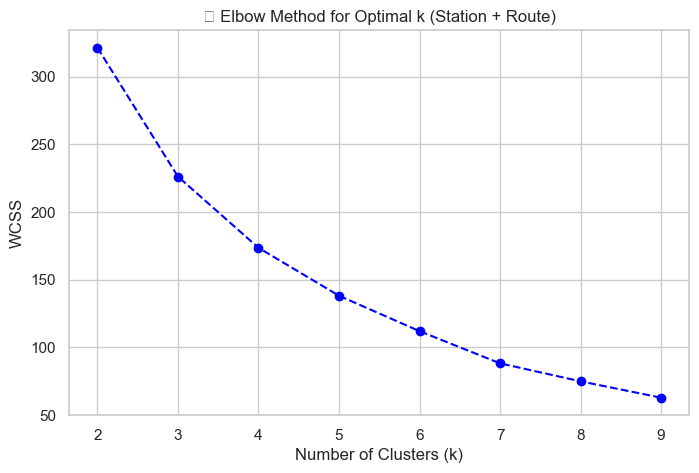

In [222]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--', color='blue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("📉 Elbow Method for Optimal k (Station + Route)")
plt.grid(True)
plt.show()

In [218]:
# Select features for clustering
clustering_features = ['CV', 'Rolling_CV']
df_cluster = df.groupby(["Station", "Route"])[clustering_features].mean().dropna()

# Find optimal clusters 
wcss = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

KeyError: "Columns not found: 'CV'"

In [ ]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--', color='blue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("📉 Elbow Method for Optimal k (Station + Route)")
plt.grid(True)
plt.show()

In [211]:
# Define Target Variable
target = "Total Flow"

# Feature Set 1: Time-based only
features_1 = ['Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos']
X_fs1 = df[features_1]
y = df[target]

# Feature Set 2: Adding Lag Features
features_2 = features_1 + ['Total Flow t-1', 'Total Flow t-2', 'Total Flow t-3', 'Total Flow t-4', 'Total Flow t-5', 'Total Flow t-6', 'Total Flow t-7']
X_fs2 = df[features_2]

# Feature Set 3: Adding Rolling Statistics
features_3 = features_1 + ['Rolling Mean (24h)', 'Rolling Std (24h)', 'Rolling Min (24h)', 'Rolling Max (24h)', 
                           'Rolling Mean (7d)', 'Rolling Std (7d)', 'Rolling Min (7d)', 'Rolling Max (7d)']
X_fs3 = df[features_3]

# Feature Set 4: Adding CV Metrics
features_4 = features_3 + ['CV', 'Rolling_CV']
X_fs4 = df[features_4]

# Feature Set 5: Adding Station & Route Info
features_5 = features_4 + ['Station', 'Route']
X_fs5 = df[features_5]